<a href="https://colab.research.google.com/github/rybread1/coronavirus-tweet-nlp/blob/master/coronavirus_tweet_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

     |████████████████████████████████| 890kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 33.1MB/s 
     |████████████████████████████████| 3.0MB 39.3MB/s 
     |████████████████████████████████| 890kB 35.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b89054f8e349b59ba7e8c28349020829f658bdf462907b93c46c32e8d33fd43f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import math
import seaborn as sn
import tensorflow as tf
import tensorflow_datasets as tfds
from bs4 import BeautifulSoup
from sklearn import metrics as sk_metrics
import nltk
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
folder = '/content/gdrive/My Drive/corona-tweet-sent'
train_f = 'Corona_NLP_train.csv'
test_f = 'Corona_NLP_test.csv'

df_train = pd.read_csv(os.path.join(folder, train_f), engine='python')
df_test = pd.read_csv(os.path.join(folder, test_f), engine='python')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
df_train['OriginalTweet'].iloc[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [8]:
y_map = {
    'Positive': 0, 
    'Negative': 1, 
    'Neutral': 2, 
    'Extremely Positive': 3, 
    'Extremely Negative': 4
}

df_train['Sentiment_Cat'] = df_train['Sentiment'].map(y_map)
df_test['Sentiment_Cat'] = df_test['Sentiment'].map(y_map)

In [9]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def clean_text(data):
    data = data.lower()
    data = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', data)
    data = re.sub(r'([^a-zA-Z\s])', '', data)
    data = data.split()
    temp = []
    for i in data:
        if i not in stop_words:
            temp.append(i)
    data = ' '.join(temp)
    return data

df_train['tweet_cleaned'] = df_train['OriginalTweet'].apply(clean_text)
df_test['tweet_cleaned'] = df_test['OriginalTweet'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
x_train, y_train = df_train['tweet_cleaned'].values, np.array(df_train['Sentiment_Cat'], dtype=np.int64)
x_test, y_test = df_test['tweet_cleaned'].values, np.array(df_test['Sentiment_Cat'], dtype=np.int64)

In [11]:
from tokenizers import BertWordPieceTokenizer
import transformers

In [12]:
# First load the real tokenizer
# tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower=True)
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased', lower=True)

# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [13]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=200):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [14]:
max_len=100

x_train_enc = fast_encode(x_train, fast_tokenizer, maxlen=max_len)
x_test_enc = fast_encode(x_test, fast_tokenizer, maxlen=max_len)

In [15]:
NUM_CLASSES = df_train['Sentiment_Cat'].nunique()

# bert_transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)

input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
sequence_output = bert_transformer(input)[0]
# cls_token = sequence_output[:, 0, :]
# output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cls_token)

model = tf.keras.Model(inputs=input, outputs=sequence_output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
tf_bert_for_sequence_classif ((None, 5),)              109486085 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [17]:
# call backs
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    x_train_enc,
    y_train,
    batch_size=16,
    validation_data=(x_test_enc, y_test),
    epochs=50,
    callbacks=[early_stop_callback])

Epoch 1/50
2573/2573 [==============================] - 1749s 680ms/step - loss: 0.9260 - accuracy: 0.6323 - val_loss: 0.7608 - val_accuracy: 0.7299
Epoch 2/50
2573/2573 [==============================] - 1741s 677ms/step - loss: 0.6310 - accuracy: 0.7778 - val_loss: 0.7289 - val_accuracy: 0.7446
Epoch 3/50
2573/2573 [==============================] - 1734s 674ms/step - loss: 0.5329 - accuracy: 0.8173 - val_loss: 0.6981 - val_accuracy: 0.7567
Epoch 4/50
2573/2573 [==============================] - 1730s 672ms/step - loss: 0.4509 - accuracy: 0.8486 - val_loss: 0.7833 - val_accuracy: 0.7341
Epoch 5/50
2573/2573 [==============================] - 1726s 671ms/step - loss: 0.3748 - accuracy: 0.8790 - val_loss: 0.7402 - val_accuracy: 0.7609
Epoch 6/50
2573/2573 [==============================] - 1725s 670ms/step - loss: 0.3131 - accuracy: 0.9009 - val_loss: 0.8165 - val_accuracy: 0.7314


In [21]:
np.argmax(ypred, axis=1)

array([1, 3, 3, ..., 2, 4, 3])

In [22]:
ypred = model.predict(x_test_enc)
# df_test['ypred'] = ypred
# df_test['ypred_cat'] = np.where(df_test['ypred']>=0.5, 1, 0)
df_test['ypred_cat'] = np.argmax(ypred, axis=1)

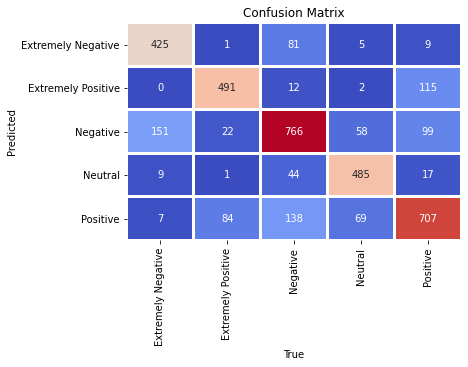

In [24]:
y_map_inv = {
    0: 'Positive',
    1: 'Negative',
    2: 'Neutral',
    3: 'Extremely Positive',
    4: 'Extremely Negative',
}

sns.heatmap(
    pd.crosstab(df_test['ypred_cat'].map(y_map_inv), df_test['Sentiment_Cat'].map(y_map_inv)),
    annot=True,
    fmt='0.0f',
    cbar=False,
    linewidth=2,
    cmap='coolwarm'     
)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix');